# Using PyTorch and BERT for Financial News

## EDA

A Financial Phrasebank was developed for a paper published by Malo et al <cite data-cite="8277123/Q3X6FHBI"></cite>. It is available for download on [Kaggle](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/financialnews.csv', encoding='latin1', header=None)
df.columns = ['label', 'text']
df.drop_duplicates(inplace=True)

Let's get a rough idea of the number of examples for each category:

<AxesSubplot:>

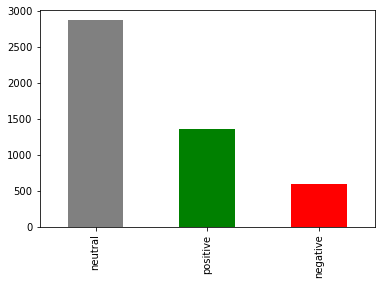

In [2]:
df['label'].value_counts().plot(kind='bar', color=['grey', 'green', 'red'])

In [3]:
# let's create some summary statistics
average_characters = round(df['text'].str.len().mean())
average_words = round(np.array([len(sentence.split()) for sentence in df['text'].values]).mean())
print('Average character count:', average_characters)
print('Average word count:', average_words)

df['label'].value_counts() / df['label'].value_counts().sum()

Average character count: 128
Average word count: 23


neutral     0.593595
positive    0.281612
negative    0.124793
Name: label, dtype: float64

In [4]:
df['label'].replace('neutral', 0, inplace=True)
df['label'].replace('positive', 1, inplace=True)
df['label'].replace('negative', 2, inplace=True)
df.head(3)

,label,text
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...


## Processing and Tokenizing the Data

As mentioned preivously, we have to add special tokens to the start and end of each sentence - `[SEP]` and `[CLS`] respectively. Subsequently, we pad and truncate all sentences to a pre-defined length, then explicitly differentiate real tokens from padding tokens with the attention mask.

BERT has two constraints:

1. All sentences must be padded or truncated to a single, fixed length
2. The maximum sequence length is 512 tokens

Padding is done with the `[PAD]` token, which is of index 0 in the BERT vocabulary. The attention mask is a simple binary array indicating which tokens are padding and which ones are not. This mask tells the previously described 'self-attention' mechanism in BERT *not* to incorporate the `[PAD]` tokens into its interpretation of the sentence.

In [5]:
import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lowercase=True)

In [7]:
class FinancialPhrasebank(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Before we start, we should create split the data using `train_test_split`:

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

df_train.shape, df_val.shape, df_test.shape

((4356, 2), (242, 2), (242, 2))

In [9]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FinancialPhrasebank(
        texts=df['text'].to_numpy(),
        targets=df['label'].to_numpy().astype(int),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size)

BATCH_SIZE = 16
MAX_LEN = 120

train_dataloader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)    

In [10]:
data = next(iter(train_dataloader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [11]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16])


## Training

### BertForSequenceClassification

The documentation for the BERT models under transformers can be found [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html). I will be using `BertForSequenceClassification`, which is a normal BERT model with an added linear layer on top for classification. The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained).

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

model.cuda() # use GPU

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Optimizer and Learning Rate Scheduler

Suggested values from the paper:
- **Batch size:** 16, 32
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
- **Number of epochs:** 2, 3, 4

In [13]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

from transformers import get_linear_schedule_with_warmup

epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Training Loop

In [14]:
# Some functions to record training metrics

import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
import random

if torch.cuda.is_available():
    device = torch.device('cuda')    
    
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []  # store training stats
total_t0 = time.time()

for epoch_i in range(epochs):
    print("\n========== Epoch {:} / {:} ==========".format(epoch_i + 1, epochs))
    t0 = time.time()
    total_training_loss = 0
    
    model.train()  # turn on training mode; doesn't actually start training
    
    for step, batch in enumerate(train_dataloader):
        
        # update progress every 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        # unpack training batch from dataloader, and copy each tensor to the GPU
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['targets'].to(device)
        
        # clear previously calculated gradients
        model.zero_grad()
        
        # perform forward pass
        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        
        # accumulate training loss
        total_training_loss += loss.item()
        
        # perform backward pass
        loss.backward()
        
        # clip the norm of the gradients to 1.0, which prevents exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters and take a step
        optimizer.step()
        
        # update learning rate
        scheduler.step()
        
    avg_training_loss = total_training_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("\n  Average training loss: {0:.2f}".format(avg_training_loss))
    print("  Epoch duration: {:}".format(training_time))

    # ===============================
    #           Validation
    # ===============================
    print("\n Running Validation...")
    t0 = time.time()

    # turn on evaluation mode
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['targets'].to(device)

        with torch.no_grad():
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        total_eval_loss += loss.item()

        # move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # report final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(val_dataloader)

    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation Duration: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_training_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("\n Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


========== Epoch 1 / 2 ==========
  Batch    40  of    273.    Elapsed: 0:00:08.
  Batch    80  of    273.    Elapsed: 0:00:16.
  Batch   120  of    273.    Elapsed: 0:00:24.
  Batch   160  of    273.    Elapsed: 0:00:32.
  Batch   200  of    273.    Elapsed: 0:00:39.
  Batch   240  of    273.    Elapsed: 0:00:47.

  Average training loss: 0.56
  Epoch duration: 0:00:53

 Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.41
  Validation Duration: 0:00:01

========== Epoch 2 / 2 ==========
  Batch    40  of    273.    Elapsed: 0:00:08.
  Batch    80  of    273.    Elapsed: 0:00:15.
  Batch   120  of    273.    Elapsed: 0:00:23.
  Batch   160  of    273.    Elapsed: 0:00:31.
  Batch   200  of    273.    Elapsed: 0:00:39.
  Batch   240  of    273.    Elapsed: 0:00:46.

  Average training loss: 0.27
  Epoch duration: 0:00:53

 Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.44
  Validation Duration: 0:00:01

 Training complete!
Total training took 0:01:48 (h:mm:ss)


## Making Predictions on the Test Set

In [16]:
# Prediction on test set

print('Predicting labels...')

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['targets'].to(device)

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('Completed.')

Predicting labels...
Completed.


### Compute the Matthews correlation coefficient (MCC)

The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.

The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.

\begin{equation}
\text{MCC} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
\end{equation}

In this equation, TP is the number of true positives, TN the number of true negatives, FP the number of false positives and FN the number of false negatives.

In [17]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

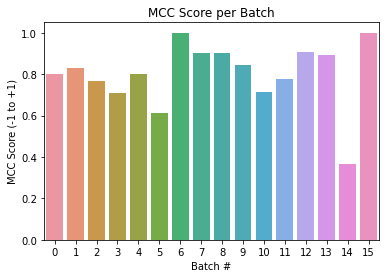

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [19]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.799


## Saving the Model

Both the configuration and the tokenizer can be saved using `save_pretrained()`. In subsequent work, it can be loaded using `from_pretrained()`.

In [20]:
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')